<a href="https://colab.research.google.com/github/dangduong2806/google-colab/blob/main/Copy2.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving colors1.csv to colors1 (1).csv


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import pandas as pd
import transformers
from tensorflow.keras.layers import Input, Dense, Lambda

In [ ]:
df = pd.read_csv("colors1.csv")
df.head()

,name,red,green,blue
0,parakeet,174,182,87
1,saddle brown,88,52,1
2,cucumber crush,222,237,215
3,pool blue,134,194,201
4,distance,98,110,130


Standardize data

In [ ]:
df["red"] = df["red"] / 255
df["green"] = df["green"] / 255
df["blue"] = df["blue"] / 255
df.head()

,name,red,green,blue
0,parakeet,0.682353,0.713725,0.341176
1,saddle brown,0.345098,0.203922,0.003922
2,cucumber crush,0.870588,0.929412,0.843137
3,pool blue,0.525490,0.760784,0.788235
4,distance,0.384314,0.431373,0.509804


In [ ]:
len(df["name"])

14357

Tách input và output

In [ ]:
X_texts = df['name'].astype(str).values
y_rgb = df[['red', 'green', 'blue']].values

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Tách train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_texts, y_rgb, test_size=0.2, shuffle = True, random_state=42
)

In [ ]:
from transformers import BertTokenizer


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize_text(texts):
    texts = list(texts)
    encodings = tokenizer(texts, padding=True, truncation=True, return_tensors="tf")
    return {
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"],
        "token_type_ids": encodings["token_type_ids"]
    }

In [ ]:
from transformers import TFBertModel

In [ ]:
def create_bert_to_rgb_model():
    bert = TFBertModel.from_pretrained("bert-base-uncased")
    # for layer in bert.layers:
    #     layer.trainable = False  # freeze toàn bộ BERT

    bert.trainable = False

    input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name="attention_mask")

    # Combined Lambda layer that does both BERT call and CLS extraction
    cls_token = tf.keras.layers.Lambda(
        lambda x: bert(input_ids=x[0], attention_mask=x[1]).last_hidden_state[:, 0, :],
        output_shape=(768,)
    )([input_ids, attention_mask])

    # Chỉ train lớp này
    x = tf.keras.layers.Dense(128, activation="relu")(cls_token)
    x = tf.keras.layers.Dense(3, activation="sigmoid")(x)  # sigmoid vì RGB chuẩn hóa [0, 1]

    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=x)
    return model

In [ ]:
model = create_bert_to_rgb_model()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
train_tokens = tokenize_text(X_train)
val_tokens = tokenize_text(X_val)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="mse",
    metrics=["mae"]
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.weights.h5',  # Must end with .weights.h5
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Khởi tạo callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # theo dõi val_loss (có thể là 'val_accuracy' tùy bài toán)
    factor=0.5,              # mỗi lần giảm thì LR = LR * factor
    patience=5,              # nếu sau 5 epoch val_loss không cải thiện thì giảm LR
    min_lr=1e-6,             # learning rate nhỏ nhất có thể giảm tới
    verbose=1                # in log khi learning rate thay đổi
)

In [ ]:
history = model.fit(
    train_tokens,
    y_train,
    validation_data=(val_tokens, y_val),
    epochs=100,
    batch_size=16,
    shuffle = True,
    callbacks=[
        checkpoint, reduce_lr, tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)


Epoch 1/40
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5699 - loss: 0.2125
Epoch 1: val_accuracy improved from -inf to 0.61247, saving model to best_model.weights.h5
718/718 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.5700 - loss: 0.2124 - val_accuracy: 0.6125 - val_loss: 0.1962
Epoch 2/40
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6366 - loss: 0.1925
Epoch 2: val_accuracy improved from 0.61247 to 0.66191, saving model to best_model.weights.h5
718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.6367 - loss: 0.1925 - val_accuracy: 0.6619 - val_loss: 0.1873
Epoch 3/40
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6508 - loss: 0.1847
Epoch 3: val_accuracy improved from 0.66191 to 0.66852, saving model to best_model.weights.h5
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6508 - loss: 0.1847 - val_accuracy: 0.6685 - val_loss: 0.1837
Epoch 4/40
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6699 - loss: 0.1799
Epoch 4: val_acc

In [ ]:

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2, 2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

In [ ]:
def predict(name):
    name = name.lower()
    # Tokenize input (chuẩn cho BERT)
    encoded = tokenizer(
        name,
        padding='max_length',
        truncation=True,
        max_length=16,  # hoặc dài hơn nếu bạn muốn
        return_tensors='tf'
    )

    # Dự đoán RGB
    pred = model.predict({
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"]
    }, verbose=0)[0]  # lấy [0] vì chỉ có 1 mẫu

    # Scale về 0-255
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])

    print(name + ',', 'R,G,B:', r, g, b)
    plot_rgb(pred)

Ocean
ocean, R,G,B: 46 129 138


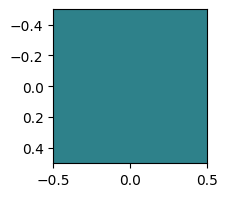

In [ ]:
n = input()
predict(n)

violet
violet, R,G,B: 144 109 138


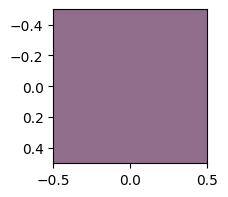

In [ ]:
n = input()
predict(n)

yellow
yellow, R,G,B: 216 197 61


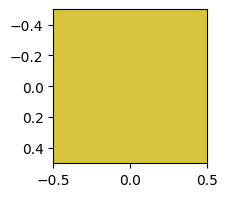

In [ ]:
n = input()
predict(n)

light yellow
light yellow, R,G,B: 237 224 96


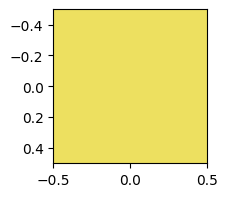

In [ ]:
n = input()
predict(n)

dark yellow
dark yellow, R,G,B: 201 153 37


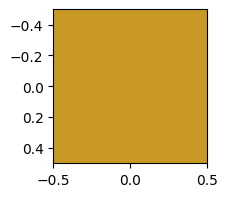

In [ ]:
n = input()
predict(n)

Evaluate

In [ ]:

from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_texts, y_rgb, test_size=0.3, shuffle = True, random_state=42
)

In [ ]:
model.load_weights("best_model.weights.h5")

In [ ]:
y_pred = model.predict(X_val)